In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



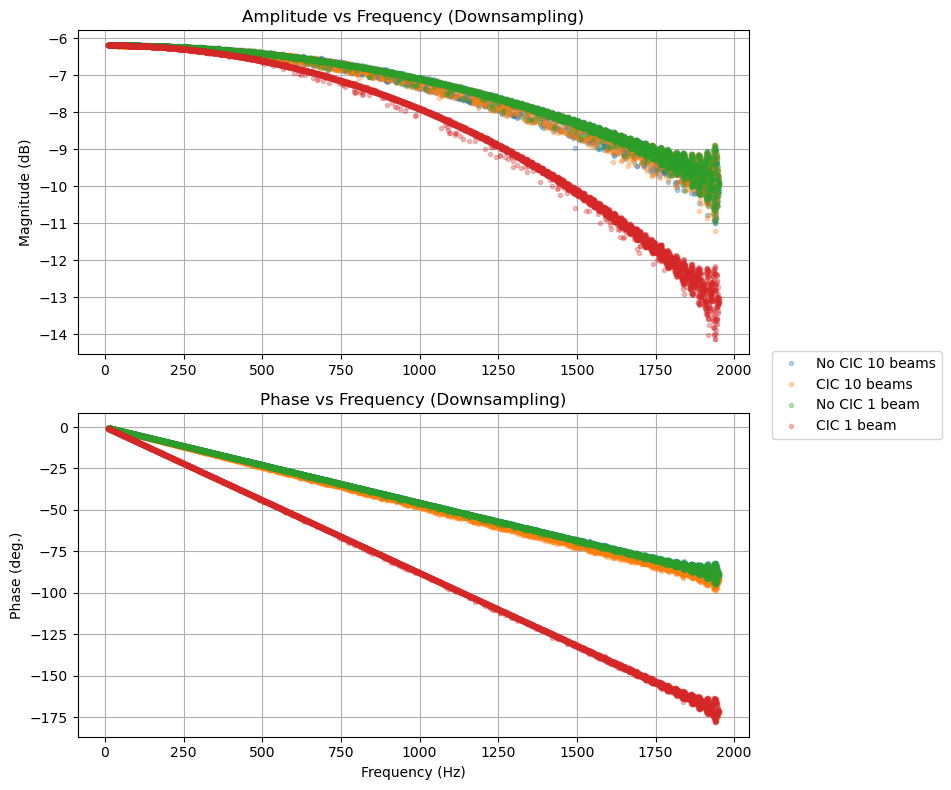

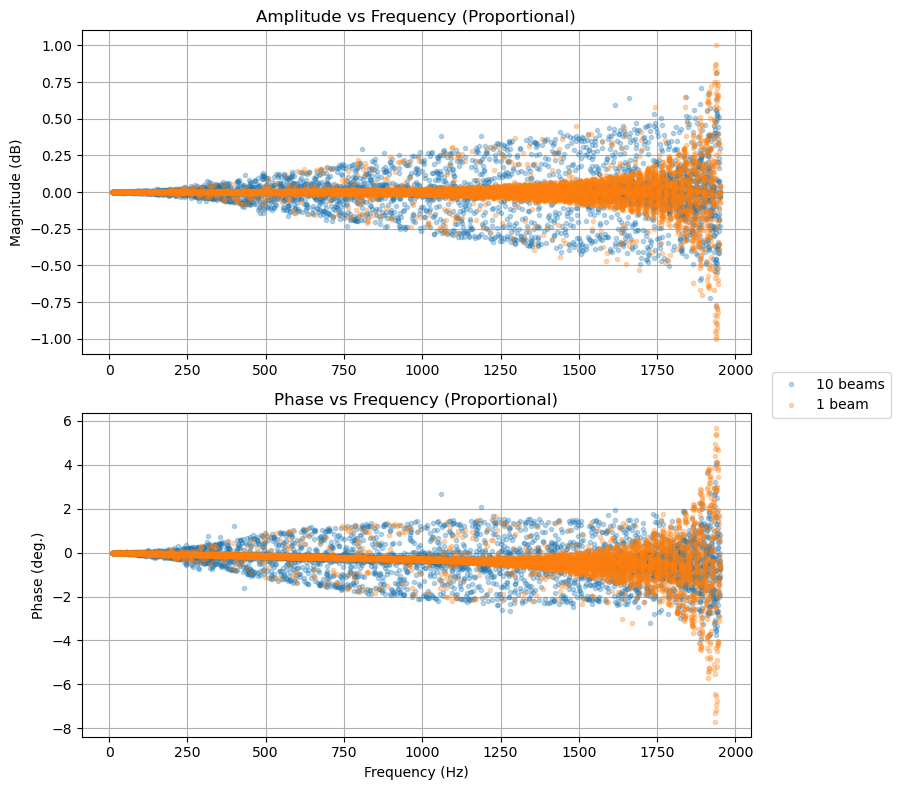

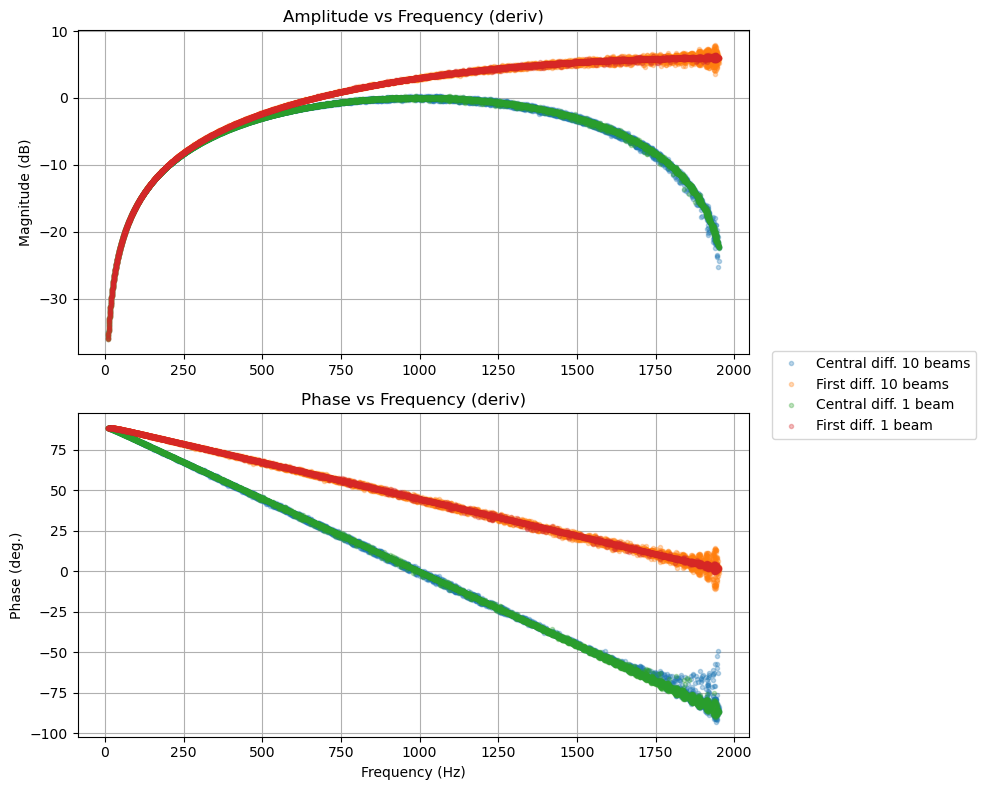

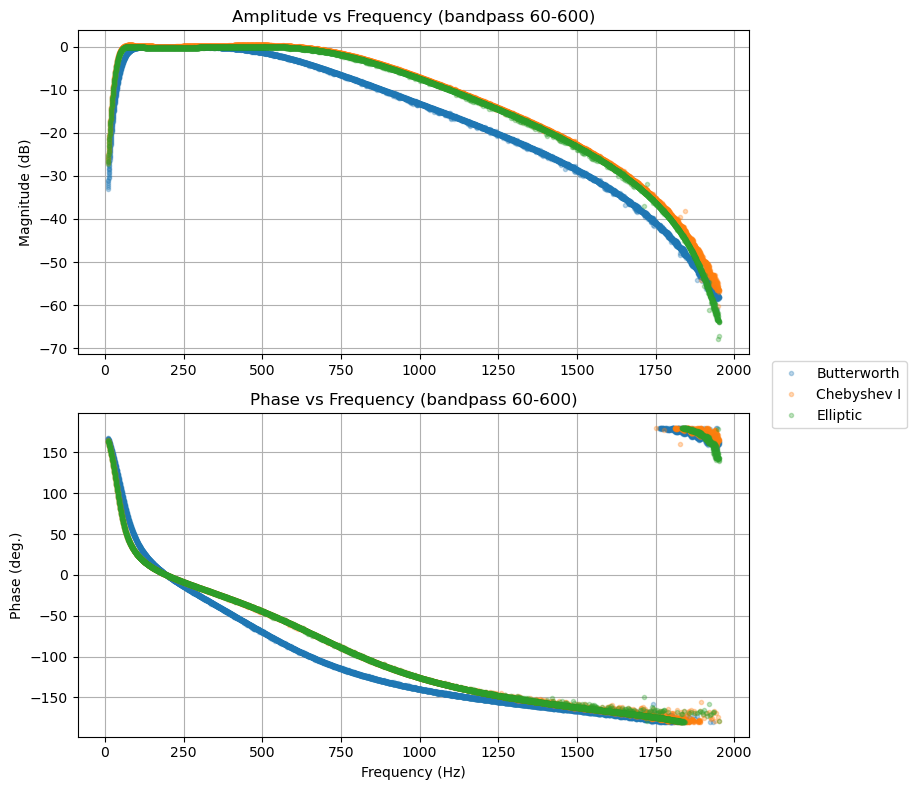

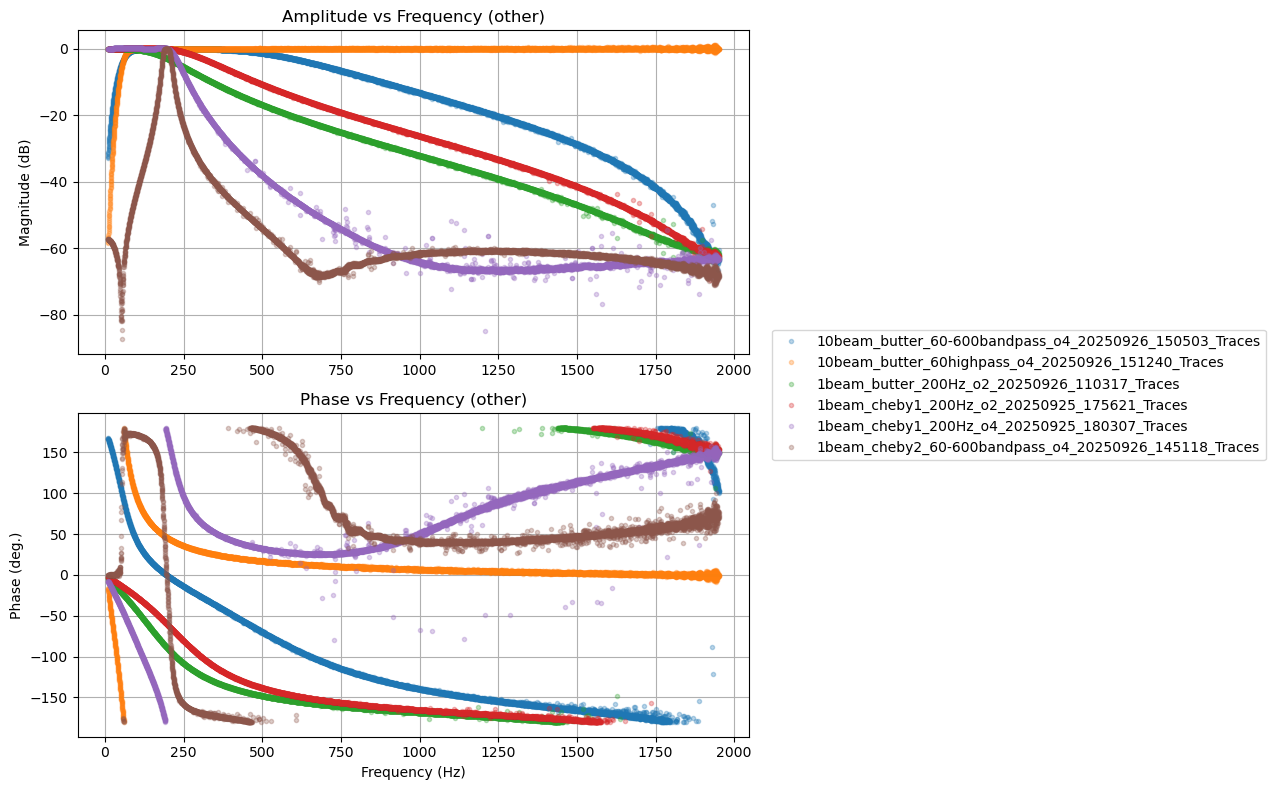

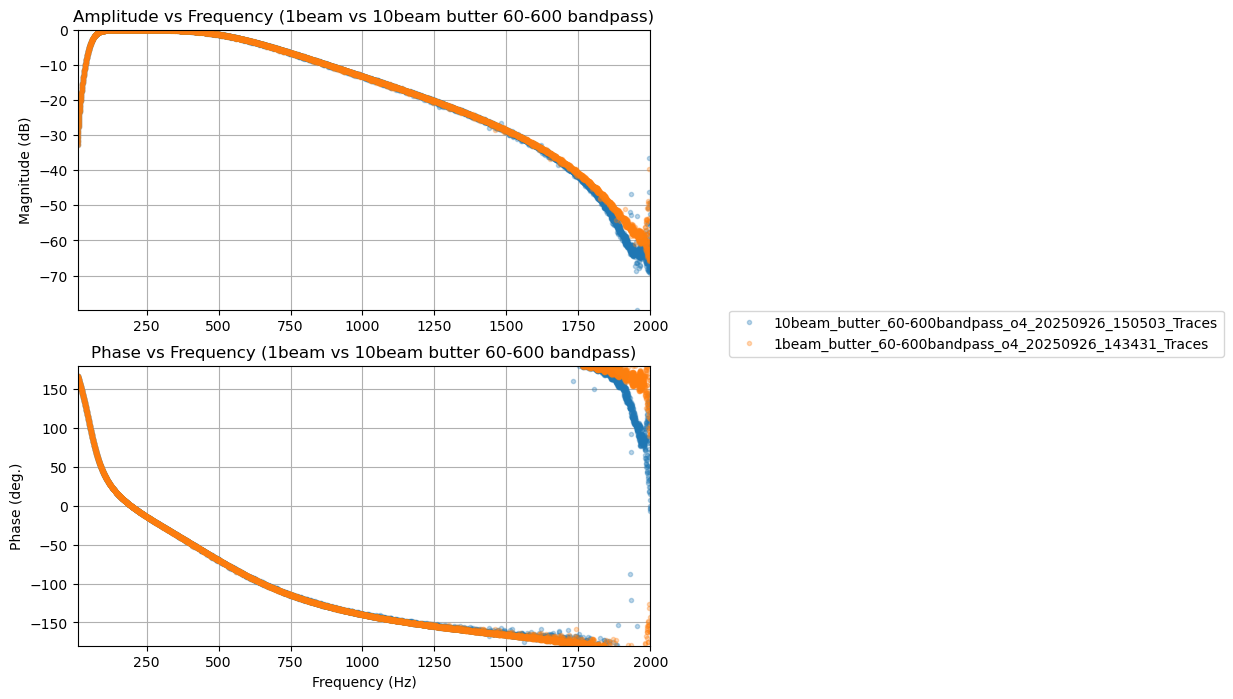

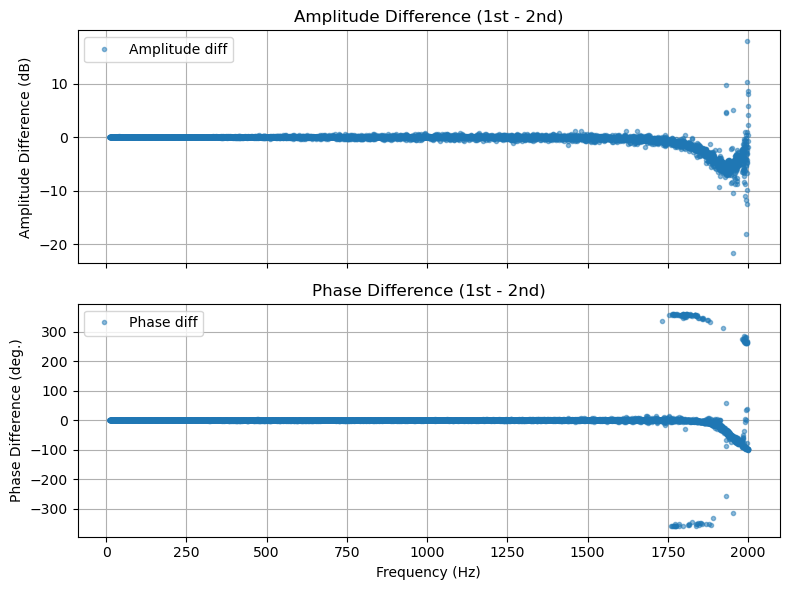

In [2]:
folder_path = r"C:\Users\bensi\Documents\20250925"
csv_files = [f for f in os.listdir(folder_path) if f.lower().endswith('.csv')]
os.chdir(r"C:\Users\bensi\Dropbox\Thesis figures")
dataframes = {}
for file in csv_files:
    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path, skiprows=8, header=None, names=["frequency", "Amplitude", "Phase"])
    # Use file name without extension as the key
    df_name = os.path.splitext(file)[0]
    dataframes[df_name] = df

#correct for response of CIC decimators
def cic_response_subtraction(df, beamnum, CIC_1, CIC_10):
    xdf = df.copy()
    xdf["Amplitude"] = df["Amplitude"] - CIC_1["Amplitude"] if beamnum == 1 else df["Amplitude"] - CIC_10["Amplitude"]
    xdf["Phase"] = df["Phase"] - CIC_1["Phase"] if beamnum == 1 else df["Phase"] - CIC_10["Phase"]

    # unwrap phase: subtract 360° where phase > 180°
    xdf["Phase"] = np.where(xdf["Phase"] > 180, xdf["Phase"] - 360, xdf["Phase"])
    xdf["Phase"] = np.where(xdf["Phase"] < -180, xdf["Phase"] + 360, xdf["Phase"])

    return xdf

# Helper function to plot dataframes on a bode plot
def plot_bode(selected_dfs, title_suffix, CIC_1, CIC_10, normalize=False, legend=None):
    fig = plt.figure(figsize=(10, 8))
    # Use gridspec to allocate only the left 3/4 for the plots
    gs = fig.add_gridspec(2, 4)
    ax1 = fig.add_subplot(gs[0, :3])
    ax2 = fig.add_subplot(gs[1, :3], sharex=ax1)

    for name, df in selected_dfs.items():
        if normalize==True:
            ndf = cic_response_subtraction(df, beamnum=1 if "1beam" in name else 10, CIC_1=CIC_1, CIC_10=CIC_10)
        else:
            ndf = df
        if "CDIF" in name:
            ndf["Amplitude"] = ndf["Amplitude"] - 6
        ax1.plot(ndf["frequency"][:-200], ndf["Amplitude"][:-200], '.', label=name, alpha=0.3)
    ax1.set_ylabel("Magnitude (dB)")
    ax1.set_title(f"Amplitude vs Frequency {title_suffix}")
    ax1.grid(True)
    #ax1.set_xlim(0, 2000)
    #ax1.set_ylim(-20, 0)  # Set y limits from -20 to 0

    for name, df in selected_dfs.items():
        if normalize==True:
            ndf = cic_response_subtraction(df, beamnum=1 if "1beam" in name else 10, CIC_1=CIC_1, CIC_10=CIC_10)
        else:
            ndf = df
        ax2.plot(ndf["frequency"][:-200], ndf["Phase"][:-200], '.', label=name, alpha=0.3)
    ax2.set_xlabel("Frequency (Hz)")
    ax2.set_ylabel("Phase (deg.)")
    ax2.set_title(f"Phase vs Frequency {title_suffix}")
    ax2.grid(True)
    #ax2.set_xlim(0, 2000)

    handles, labels = ax1.get_legend_handles_labels()
    # Place legend in the right 1/4 of the figure
    if legend == None:
        fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.77, 0.5))
    else:
        fig.legend(legend, loc='center left', bbox_to_anchor=(0.77, 0.5))
    plt.tight_layout()
    plt.show()
    return fig



# Split dataframes by name
pass_dfs = {name: df for name, df in dataframes.items() if (("pass" in name.lower()) and not any(x in name.lower() for x in ["butter", "cheby", "ellip"]))}
prop_dfs = {name: df for name, df in dataframes.items() if (("prop" in name.lower()) and not any(x in name.lower() for x in ["butter", "cheby", "ellip"]))}
deriv_dfs = {name: df for name, df in dataframes.items() if ("deriv" in name.lower() and not any(x in name.lower() for x in ["butter", "cheby", "ellip"]))}
bandpass_dfs = {name: df for name, df in dataframes.items() if ("60-600bandpass" in name.lower() and "10beam" not in name.lower() and "cheby2" not in name.lower())}
other_dfs = {name: df for name, df in dataframes.items() if name not in pass_dfs and name not in prop_dfs and name not in deriv_dfs and name not in bandpass_dfs}


# select the first matching dataframe (or None if not found)
CIC_1 = next((df for name, df in dataframes.items() if name.startswith("1beam_pass")), None)
CIC_10 = next((df for name, df in dataframes.items() if name.startswith("10beam_pass")), None)

pslegend =["No CIC 10 beams", "CIC 10 beams", "No CIC 1 beam", "CIC 1 beam"]
proplegend =["10 beams", "1 beam"]
difflegend =["Central diff. 10 beams", "First diff. 10 beams", "Central diff. 1 beam", "First diff. 1 beam"]
bplegend = ["Butterworth", "Chebyshev I", "Elliptic"]
# Plot each group
pass_fig = plot_bode(pass_dfs, "(Downsampling)", CIC_1, CIC_10, False, pslegend)
#pass_fig.savefig("FPGA_response_downsampling.png", dpi=300)
prop_fig = plot_bode(prop_dfs, "(Proportional)", CIC_1, CIC_10, True,proplegend)

#prop_fig.savefig("FPGA_response_proportional.png", False, CIC_1, CIC_10, dpi=300)
deriv_fig = plot_bode(deriv_dfs, "(deriv)", CIC_1, CIC_10, True, difflegend)

#deriv_fig.savefig("FPGA_response_derivative.png", False, CIC_1, CIC_10, dpi=300)
band_fig = plot_bode(bandpass_dfs, "(bandpass 60-600)", CIC_1, CIC_10, True,bplegend)
other_fig = plot_bode(other_dfs, "(other)", CIC_1, CIC_10, True)

# Compare specific butter bandpass dataframes
compare_butter_dfs = {name: df for name, df in dataframes.items()
                      if name.startswith("1beam_butter_60-600bandpass") or name.startswith("10beam_butter_60-600bandpass")}

def plot_bode_autoscale(selected_dfs, title_suffix):
    fig = plt.figure(figsize=(10, 8))
    gs = fig.add_gridspec(2, 4)
    ax1 = fig.add_subplot(gs[0, :3])
    ax2 = fig.add_subplot(gs[1, :3], sharex=ax1)

    # Plot amplitude
    for name, df in selected_dfs.items():
        ndf = cic_response_subtraction(df, beamnum=1 if "1beam" in name else 10, CIC_1=CIC_1, CIC_10=CIC_10)
        ax1.plot(ndf["frequency"], ndf["Amplitude"], '.', label=name, alpha=0.3)
    ax1.set_ylabel("Magnitude (dB)")
    ax1.set_title(f"Amplitude vs Frequency {title_suffix}")
    ax1.grid(True)
    ax1.autoscale(enable=True, axis='both', tight=True)

    # Plot phase
    for name, df in selected_dfs.items():
        ndf = cic_response_subtraction(df, beamnum=1 if "1beam" in name else 10, CIC_1=CIC_1, CIC_10=CIC_10)
        ax2.plot(ndf["frequency"], ndf["Phase"], '.', label=name, alpha=0.3)
    ax2.set_xlabel("Frequency (Hz)")
    ax2.set_ylabel("Phase (deg.)")
    ax2.set_title(f"Phase vs Frequency {title_suffix}")
    ax2.grid(True)
    ax2.autoscale(enable=True, axis='both', tight=True)

    # Plot difference (assumes exactly two dataframes) in a separate figure
    if len(selected_dfs) == 2:
        names = list(selected_dfs.keys())
        df1 = selected_dfs[names[0]]
        df2 = selected_dfs[names[1]]

        df1 = cic_response_subtraction(df1, beamnum=1 if "1beam" in names[0] else 10, CIC_1=CIC_1, CIC_10=CIC_10)        
        df2 = cic_response_subtraction(df2, beamnum=1 if "1beam" in names[1] else 10, CIC_1=CIC_1, CIC_10=CIC_10)        

        freq_common = df1["frequency"]
        amp1 = df1["Amplitude"]
        amp2 = df2["Amplitude"]
        phase1 = df1["Phase"]
        phase2 = df2["Phase"]

        fig_diff, (ax_amp_diff, ax_phase_diff) = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
        ax_amp_diff.plot(freq_common, amp1 - amp2, '.', label="Amplitude diff", alpha=0.5)
        ax_amp_diff.set_ylabel("Amplitude Difference (dB)")
        ax_amp_diff.set_title("Amplitude Difference (1st - 2nd)")
        ax_amp_diff.grid(True)
        ax_amp_diff.legend()

        ax_phase_diff.plot(freq_common, phase1 - phase2, '.', label="Phase diff", alpha=0.5)
        ax_phase_diff.set_xlabel("Frequency (Hz)")
        ax_phase_diff.set_ylabel("Phase Difference (deg.)")
        ax_phase_diff.set_title("Phase Difference (1st - 2nd)")
        ax_phase_diff.grid(True)
        ax_phase_diff.legend()

        plt.tight_layout()

    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.77, 0.5))
    plt.tight_layout()
    plt.show()


plot_bode_autoscale(compare_butter_dfs, "(1beam vs 10beam butter 60-600 bandpass)")


c:\Users\bensi\anaconda3\Lib\site-packages\scipy\signal\_ltisys.py:599: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  self.num, self.den = normalize(*system)
C:\Users\bensi\AppData\Local\Temp\ipykernel_10520\486369807.py:79: RuntimeWarning: divide by zero encountered in log10
  magnitude_db = 20 * np.log10(np.abs(h))
C:\Users\bensi\AppData\Local\Temp\ipykernel_10520\486369807.py:80: RuntimeWarning: divide by zero encountered in log10
  magnitude_db_o2 = 20 * np.log10(np.abs(h_o2))
C:\Users\bensi\AppData\Local\Temp\ipykernel_10520\486369807.py:81: RuntimeWarning: divide by zero encountered in log10
  magnitude_db_4 = 20 * np.log10(np.abs(h_4))
C:\Users\bensi\AppData\Local\Temp\ipykernel_10520\486369807.py:82: RuntimeWarning: divide by zero encountered in log10
  magnitude_db_50 = 20 * np.log10(np.abs(h_50))


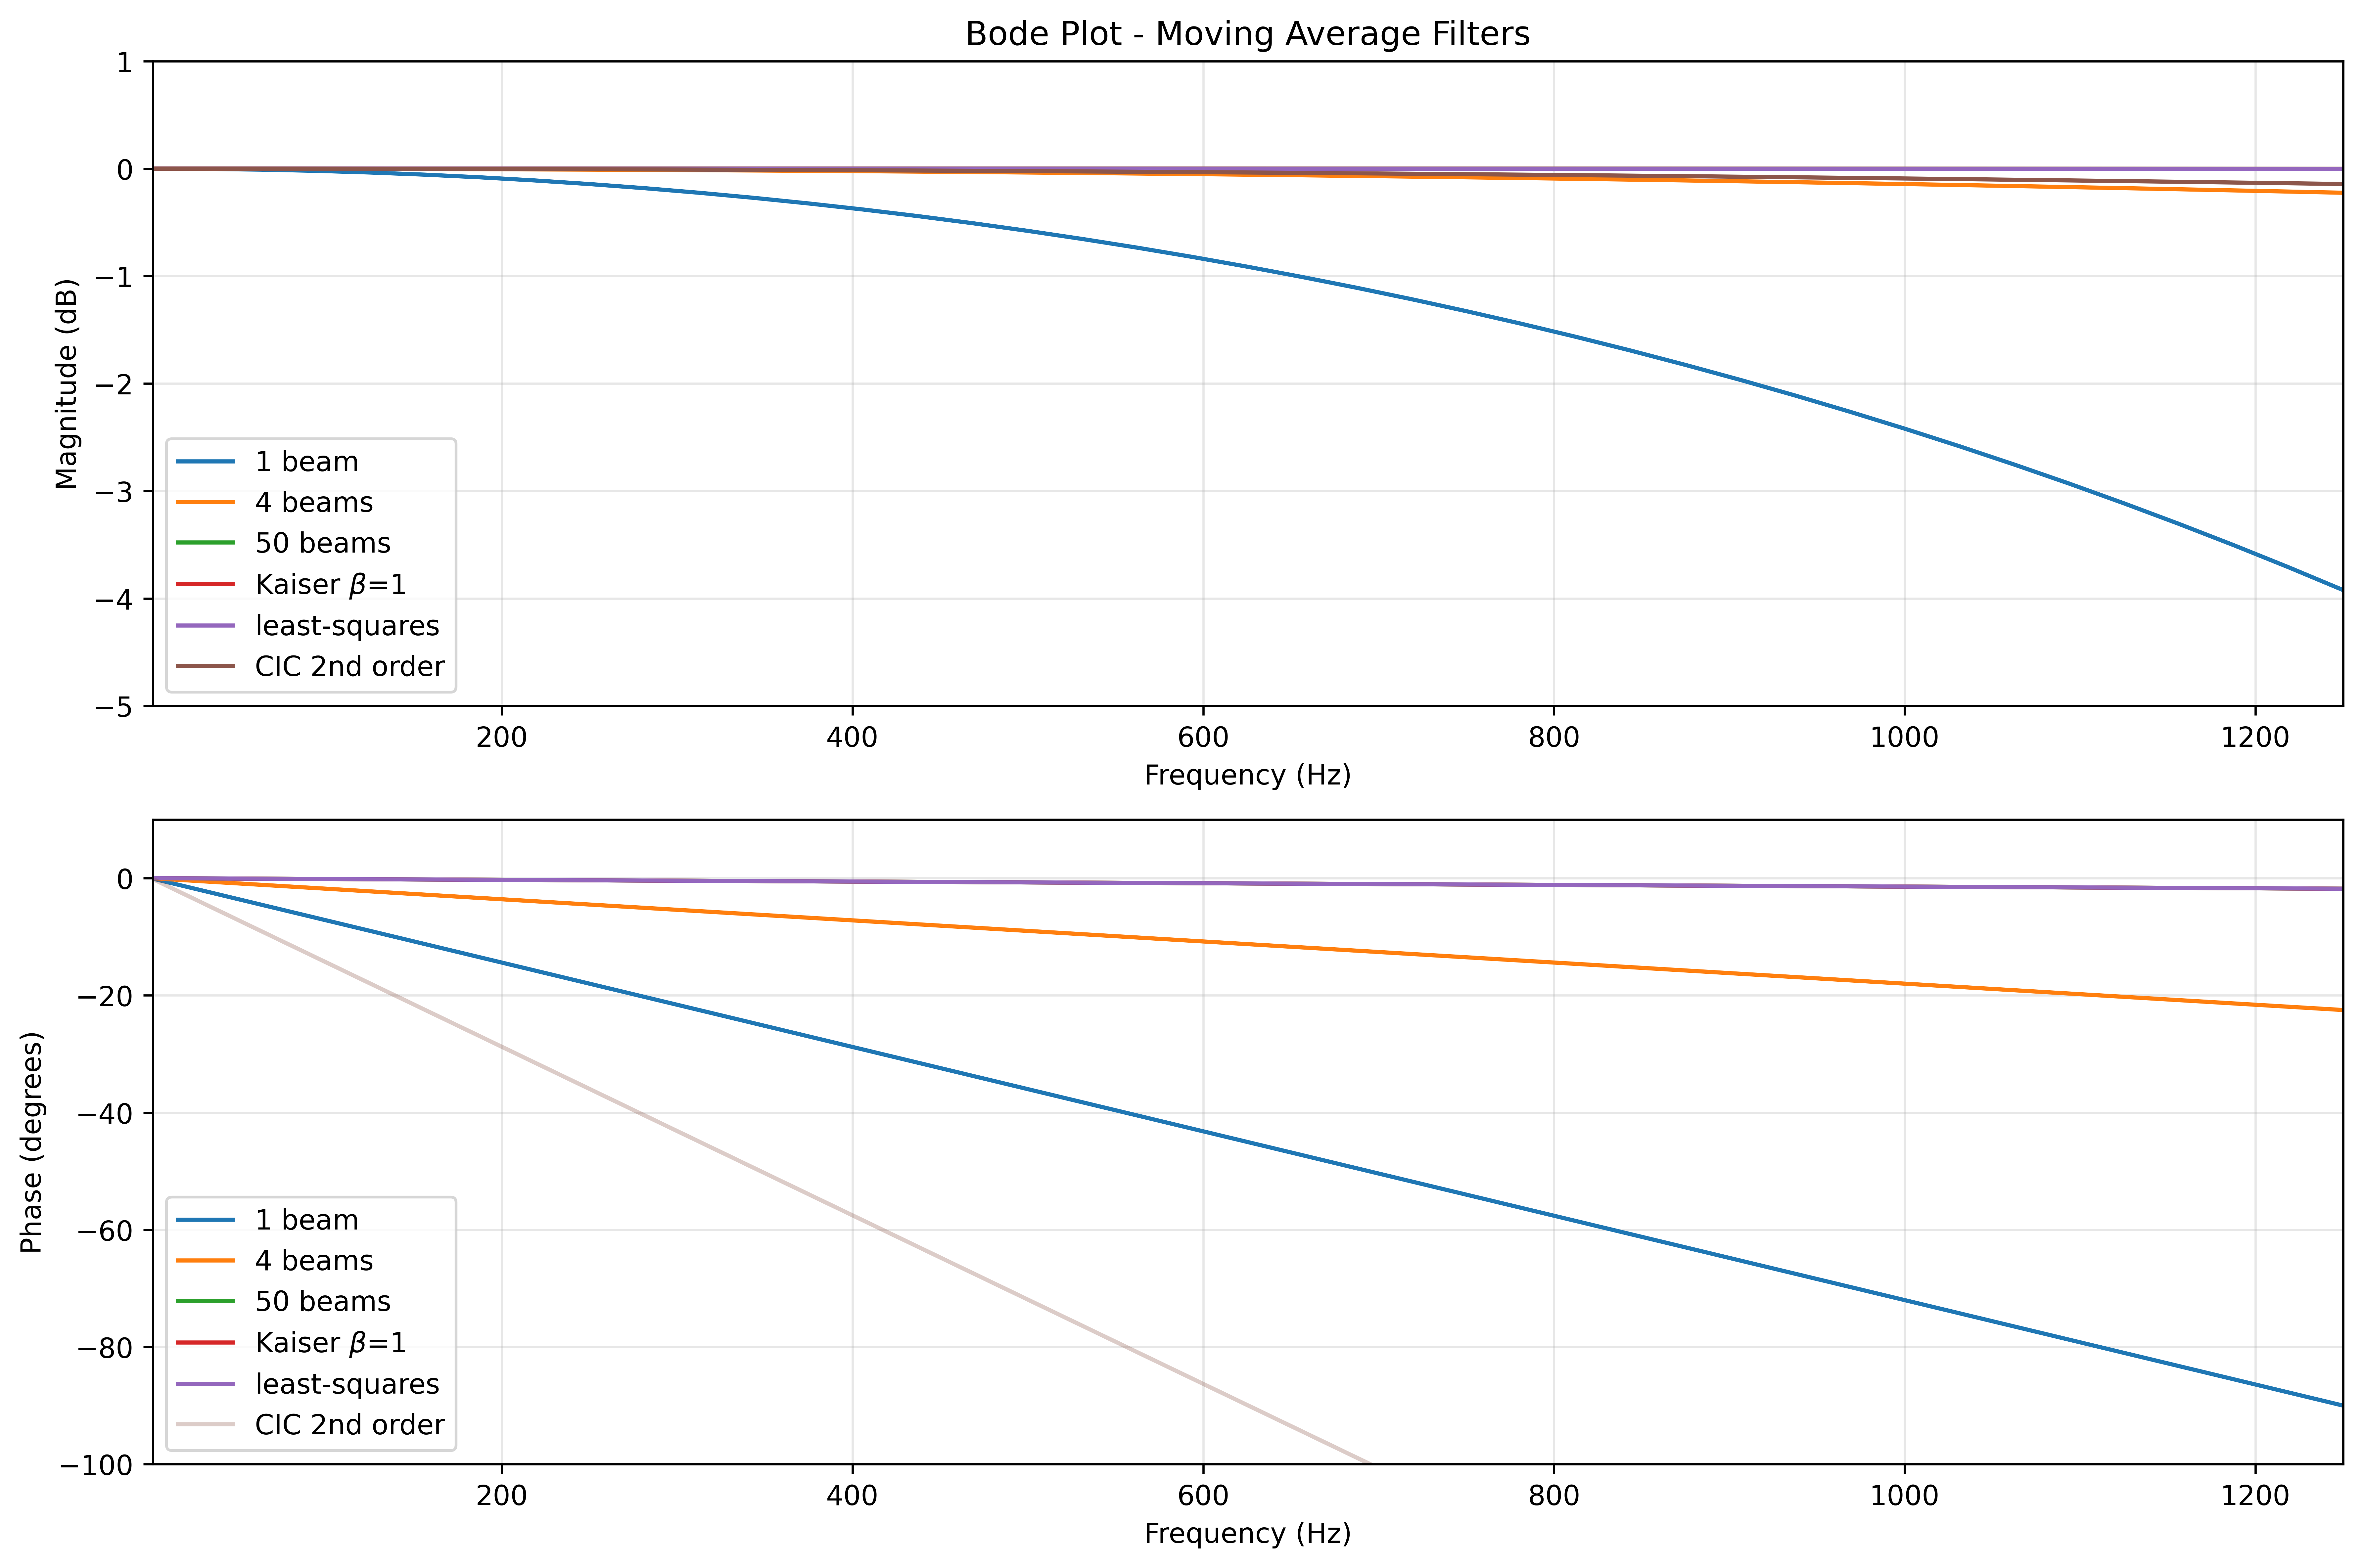

Number of major aliases: (2, 7, 82, 85, 82)


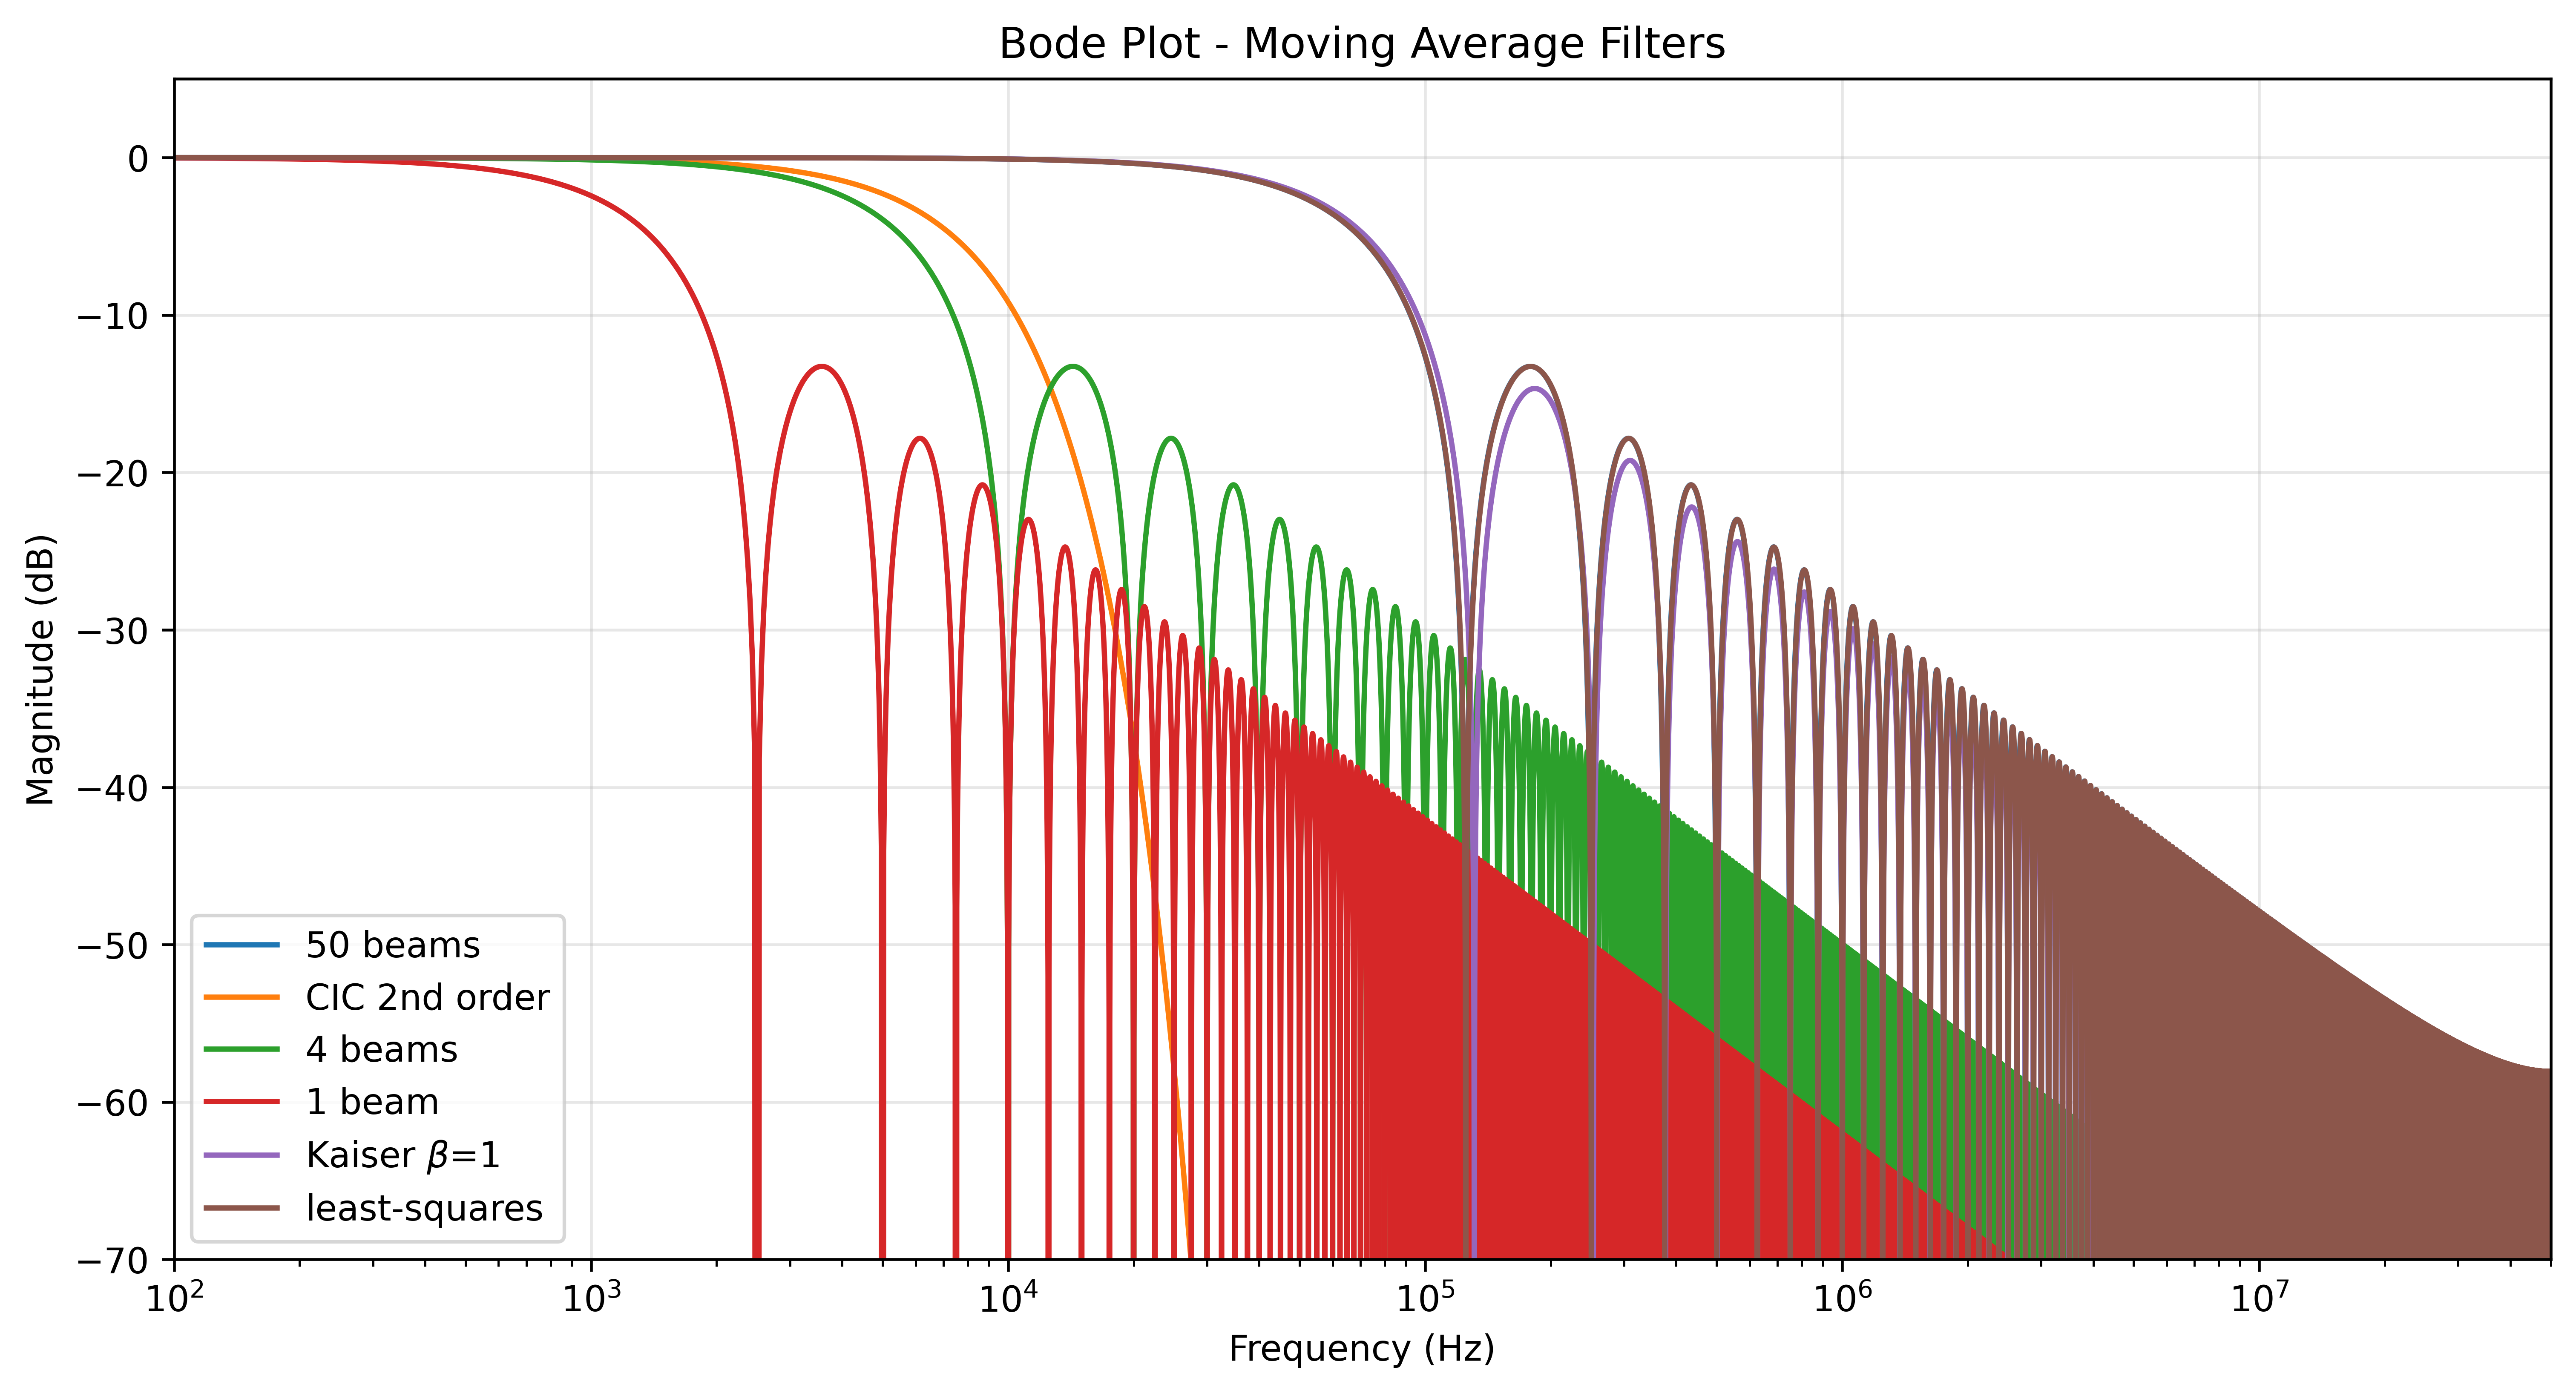

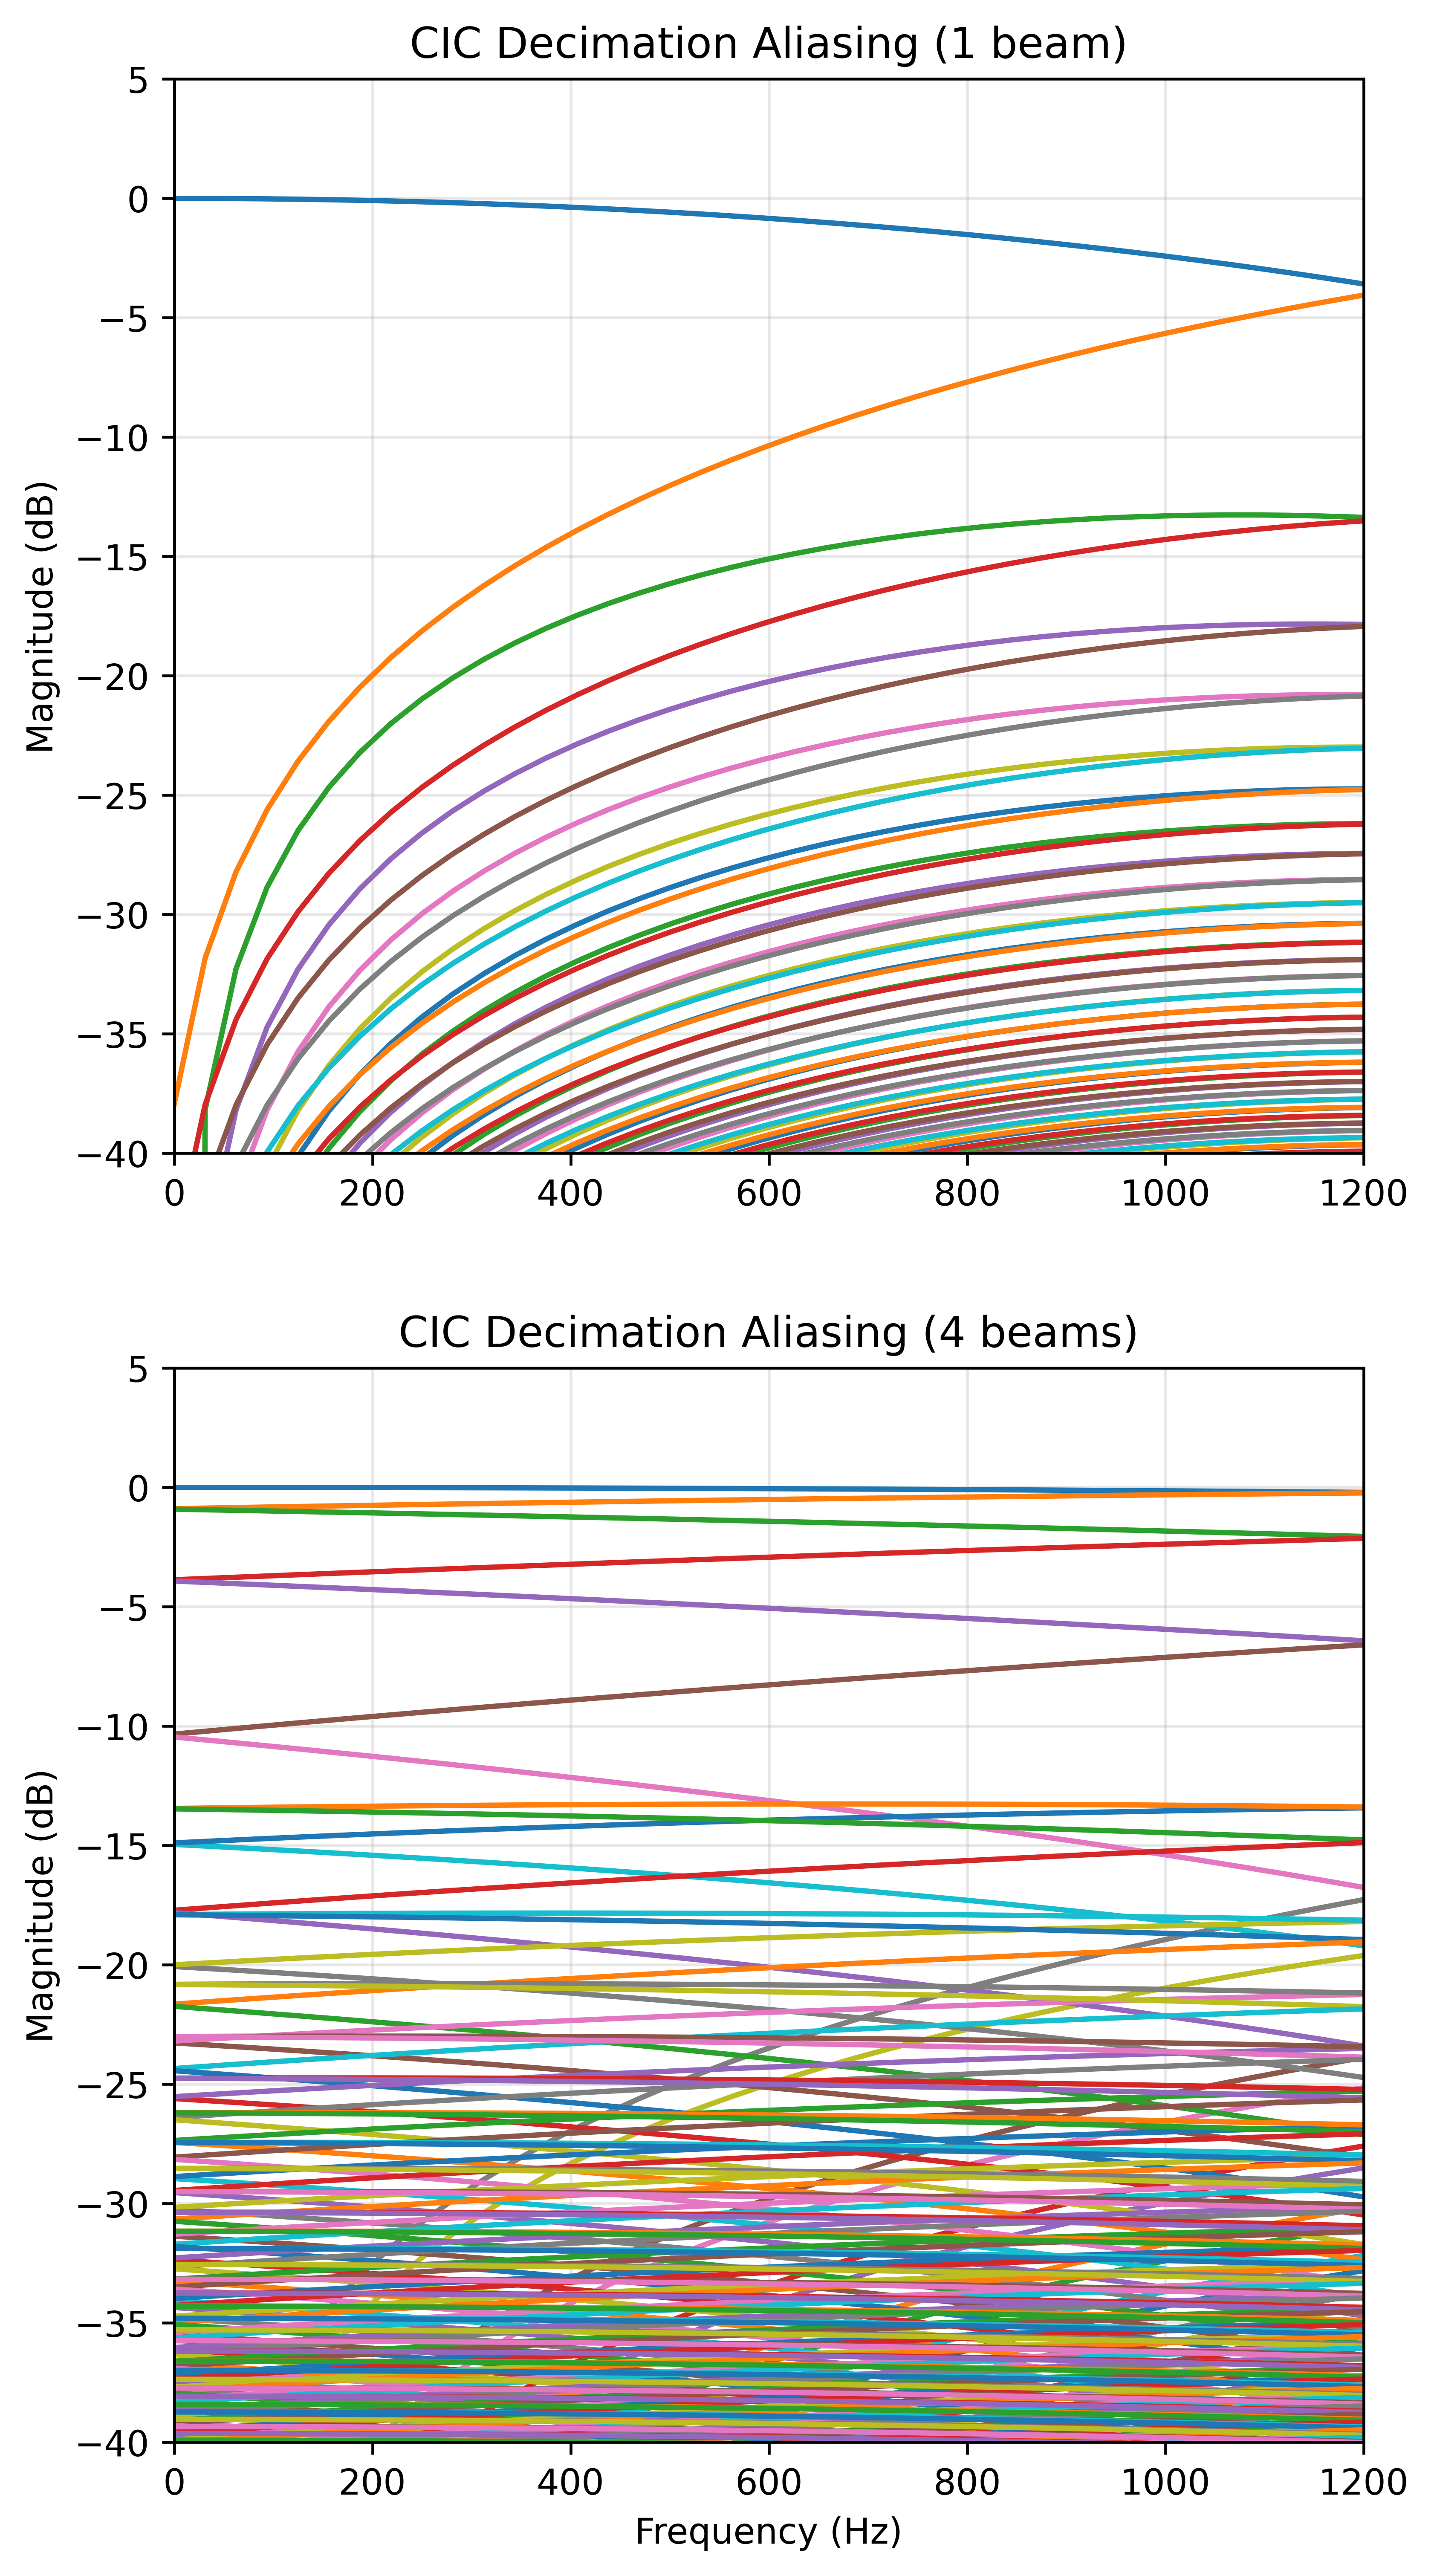

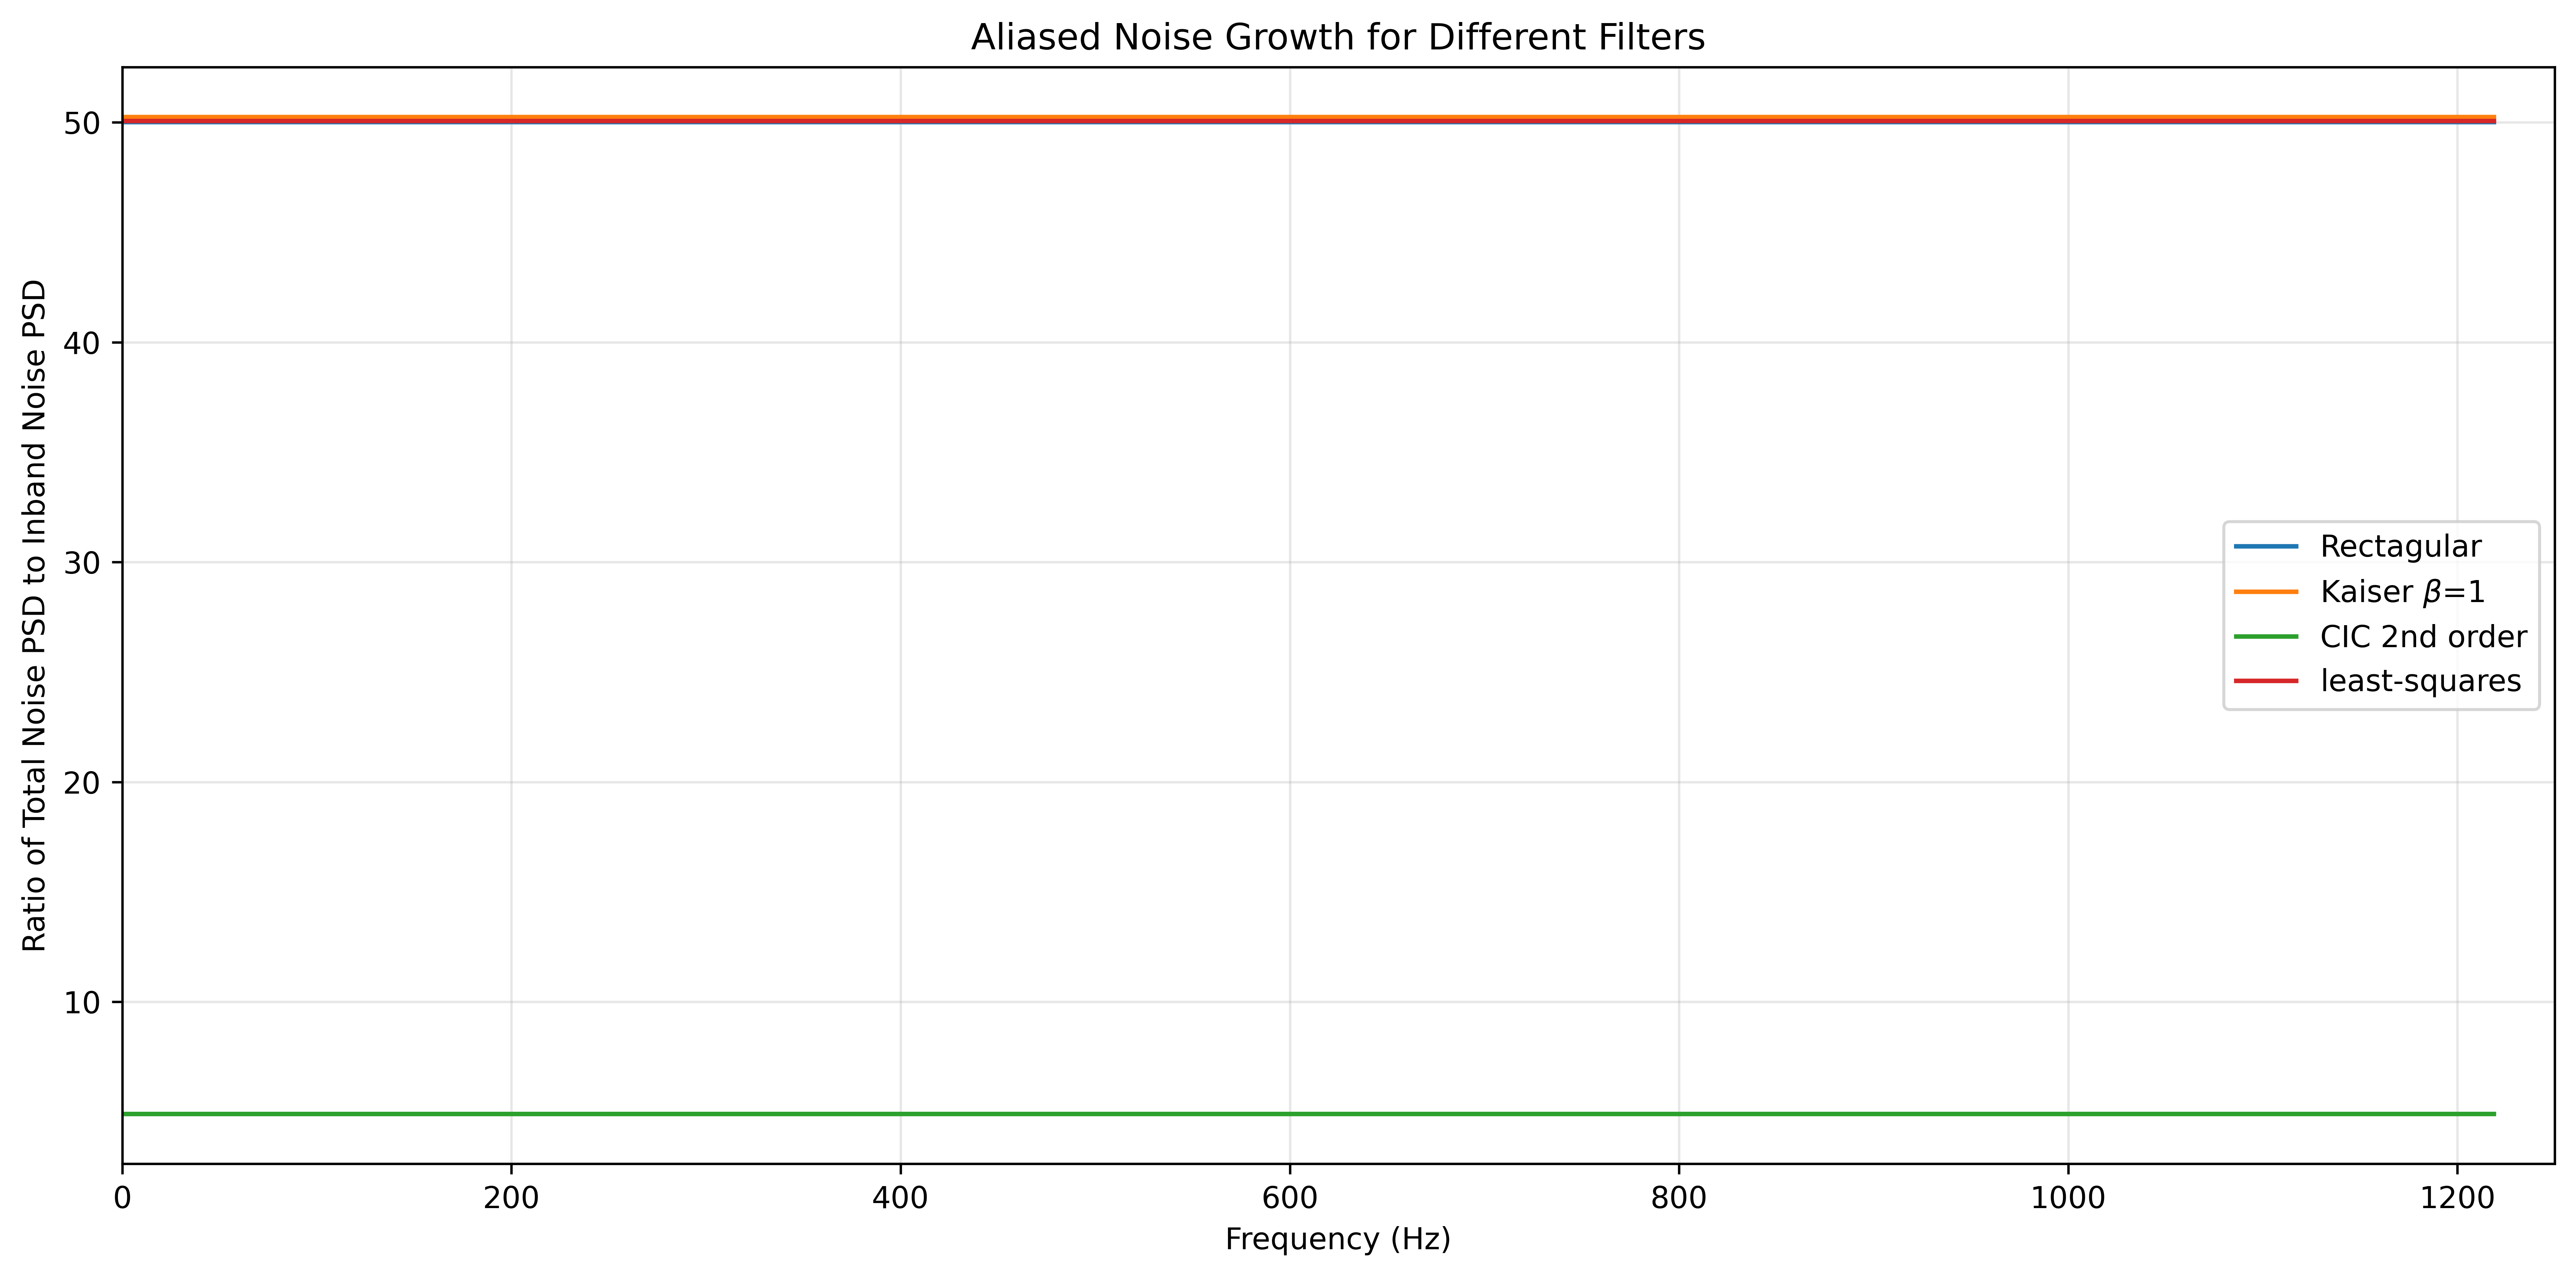

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
plt.rcParams['figure.dpi'] = 600
# Parameters
big_array_filter = 800
#For 1 beam, 10 beams, and 50 beams at effective sampling rate of 2.5kHz
filter_length = 40000  # Filter length 400us 1 beam
filter_length_4 = 10000  # Filter length 100us 4 beams
filter_length_50 = big_array_filter  # Filter length 8us
fs = 100e6  # 100 MHz sampling rate
decimation_factor = 40000
fs_new = fs / decimation_factor
f_nyquist_new = fs_new / 2

# Design 2nd order CIC filter with length big_array_filter
cic_order = 100
cic_b = np.ones(big_array_filter) / big_array_filter
for _ in range(cic_order - 1):
    cic_b = np.convolve(cic_b, np.ones(big_array_filter) / big_array_filter)
cic_b = cic_b / np.sum(cic_b)  # Normalize

# Create Kaiser window filter with length 800
beta_kaiser = 1
kaiser_window = signal.windows.kaiser(big_array_filter, beta=beta_kaiser)
b_kaiser = kaiser_window / np.sum(kaiser_window)

# Create boxcar filter coefficients
b = np.ones(filter_length) / filter_length
b_4 = np.ones(filter_length_4) / filter_length_4
b_50 = np.ones(filter_length_50) / filter_length_50
a = [1]

# Design 800-tap FIR lowpass filter using least-squares (firls)
fp = f_nyquist_new        # passband edge (Hz)
fsb = 2*f_nyquist_new            # stopband edge (Hz)
bands = [0, 2*fp, 2*fsb, fs/2]     # frequency bands in Hz (fs provided below)
desired = [1, 1, 0, 0]         # desired amplitudes in each band
b_firls = signal.firls(big_array_filter-1, bands, desired, fs=fs)
b_firls = b_firls / np.sum(b_firls)  # Normalize to unity gain in passband

# Create transfer function for the designed FIR
system_firls = signal.TransferFunction(b_firls, a)


# Create the filter system
system_o2 = signal.TransferFunction(cic_b, a)
system = signal.TransferFunction(b, a)
system_4 = signal.TransferFunction(b_4, a)
system_50 = signal.TransferFunction(b_50, a)
system_kaiser = signal.TransferFunction(b_kaiser, a)

# Generate frequency response
w, h = signal.freqz(b, a, fs=fs, worN=1600000)
w_o2, h_o2 = signal.freqz(cic_b, a, fs=fs, worN=1600000)
w_4, h_4 = signal.freqz(b_4, a, fs=fs, worN=1600000)
w_50, h_50 = signal.freqz(b_50, a, fs=fs, worN=1600000)
w_kaiser, h_kaiser = signal.freqz(b_kaiser, a, fs=fs, worN=1600000)
w_firls, h_firls = signal.freqz(b_firls, a, fs=fs, worN=1600000)

# Convert frequency to MHz for readability
f_mhz = w / 1e6

# Create white noise PSD with power A=1dB
white_noise_psd = np.ones(len(w))
# Design lowpass filter with cutoff frequency of 2MHz and sampling rate fs
cutoff_freq = 2000000
normalized_cutoff = cutoff_freq / (fs / 2)
b_lpf, a_lpf = signal.butter(4, normalized_cutoff, btype='low')

# Apply filter to white noise PSD
w_lpf, h_lpf = signal.freqz(b_lpf, a_lpf, fs=fs, worN=len(white_noise_psd))
#white_noise_psd = white_noise_psd * np.abs(h_lpf)**2

# Create Bode plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Magnitude plot (dB)
magnitude_db = 20 * np.log10(np.abs(h))
magnitude_db_o2 = 20 * np.log10(np.abs(h_o2))
magnitude_db_4 = 20 * np.log10(np.abs(h_4))
magnitude_db_50 = 20 * np.log10(np.abs(h_50))
magnitude_db_kaiser = 20 * np.log10(np.abs(h_kaiser))
magnitude_db_firls = 20 * np.log10(np.abs(h_firls))

ax1.plot(w, magnitude_db, linewidth=1.5, label='1 beam')
ax1.plot(w_4, magnitude_db_4, linewidth=1.5, label='4 beams')
ax1.plot(w_50, magnitude_db_50, linewidth=1.5, label='50 beams')
ax1.plot(w_kaiser, magnitude_db_kaiser, linewidth=1.5, label=r'Kaiser $\beta$='+str(round(beta_kaiser, 1)))
ax1.plot(w_firls, magnitude_db_firls, linewidth=1.5, label='least-squares')
ax1.plot(w_o2, magnitude_db_o2, linewidth=1.5, label='CIC 2nd order')

#for x_val in np.arange(0, fs/2, fs/(2*decimation_factor)):
#    ax1.axvline(x=x_val, color='red', linestyle='--', alpha=0.5, linewidth=0.8)

ax1.set_ylabel('Magnitude (dB)')
ax1.set_xlabel('Frequency (Hz)')
ax1.set_title(f'Bode Plot - Moving Average Filters')
ax1.grid(True, alpha=0.3)
ax1.set_xlim([1, f_nyquist_new])
ax1.set_ylim([-5, 1])
ax1.legend(loc='lower left')

# Phase plot (degrees)
phase_deg = np.angle(h, deg=True)
phase_deg_o2 = np.angle(h_o2, deg=True)
phase_deg_4 = np.angle(h_4, deg=True)
phase_deg_50 = np.angle(h_50, deg=True)
phase_deg_kaiser = np.angle(h_kaiser, deg=True)
phase_deg_firls = np.angle(h_firls, deg=True)
ax2.plot(w, phase_deg, linewidth=1.5, label='1 beam')
ax2.plot(w_4, phase_deg_4, linewidth=1.5, label='4 beams')
ax2.plot(w_50, phase_deg_50, linewidth=1.5, label='50 beams')
ax2.plot(w_kaiser, phase_deg_kaiser, linewidth=1.5, label=r'Kaiser $\beta$='+str(round(beta_kaiser, 1)))
ax2.plot(w_firls, phase_deg_firls, linewidth=1.5, label='least-squares')
ax2.plot(w_o2, phase_deg_o2, linewidth=1.5, alpha=0.3,label='CIC 2nd order')
ax2.legend(loc='lower left')
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Phase (degrees)')
ax2.grid(True, alpha=0.3)
ax2.set_xlim([1, f_nyquist_new])
ax2.set_ylim([-100, 10])

plt.tight_layout()
plt.show()

fig_whole, ax_whole = plt.subplots(figsize=(12, 6))
ax_whole.semilogx(w_50, magnitude_db_50, linewidth=1.5, label='50 beams')
ax_whole.semilogx(w_o2, magnitude_db_o2, linewidth=1.5, label='CIC 2nd order')
ax_whole.semilogx(w_4, magnitude_db_4, linewidth=1.5, label='4 beams')
ax_whole.semilogx(w, magnitude_db, linewidth=1.5, label='1 beam')
ax_whole.semilogx(w_kaiser, magnitude_db_kaiser, linewidth=1.5, label=r'Kaiser $\beta$='+str(round(beta_kaiser, 1)))
ax_whole.semilogx(w_firls, magnitude_db_firls, linewidth=1.5, label='least-squares')

#for x_val in np.arange(0, fs/2, fs/(2*decimation_factor)):
#    ax_whole.axvline(x=x_val, color='red', linestyle='--', alpha=0.5, linewidth=0.8)

ax_whole.set_ylabel('Magnitude (dB)')
ax_whole.set_xlabel('Frequency (Hz)')
ax_whole.set_title(f'Bode Plot - Moving Average Filters')
ax_whole.grid(True, alpha=0.3)
ax_whole.set_xlim([100, fs/2])
ax_whole.set_ylim([-70, 5])
ax_whole.legend(loc='lower left')

# Plot magnitude response aliased to new sampling rate

major_aliases = 0
major_aliases_4 = 0
major_aliases_50 = 0
major_aliases_kaiser = 0
major_aliases_firls = 0

noise_aliased = []
noise_aliased_kaiser = []
noise_aliased_firls = []
noise_aliased_o2 = []
fig_aliased, (ax_aliased, ax_aliased2) = plt.subplots(2,1,figsize=(6, 12))
for i in range(decimation_factor):
    x_start = int(round((len(magnitude_db)/(decimation_factor)*i)))
    x_stop  = int(round((len(magnitude_db)/(decimation_factor)*(i+1))))
    w_new = w[x_start:x_stop] - fs/2/decimation_factor*i
    if i == 0:
        noise_aliased = white_noise_psd[x_start:x_stop] * np.abs(h_50[x_start:x_stop])**2
        noise_aliased_kaiser = white_noise_psd[x_start:x_stop] * np.abs(h_kaiser[x_start:x_stop])**2
        noise_aliased_firls = white_noise_psd[x_start:x_stop] * np.abs(h_firls[x_start:x_stop])**2
        noise_aliased_o2 = white_noise_psd[x_start:x_stop] * np.abs(h_o2[x_start:x_stop])**2
    else:
        if i%2==0:
            noise_aliased = noise_aliased + white_noise_psd[x_start:x_stop] * np.abs(h_50[x_start:x_stop])**2
            noise_aliased_kaiser = noise_aliased_kaiser + white_noise_psd[x_start:x_stop] * np.abs((h_kaiser[x_start:x_stop]))**2
            noise_aliased_firls = noise_aliased_firls + white_noise_psd[x_start:x_stop] * np.abs((h_firls[x_start:x_stop]))**2
            noise_aliased_o2 = noise_aliased_o2 + white_noise_psd[x_start:x_stop] * np.abs((h_o2[x_start:x_stop]))**2
        else:
            noise_aliased = noise_aliased + white_noise_psd[x_start:x_stop] * np.flip(np.abs((h_50[x_start:x_stop]))**2)
            noise_aliased_kaiser = noise_aliased_kaiser + white_noise_psd[x_start:x_stop] * np.flip(np.abs((h_kaiser[x_start:x_stop]))**2)
            noise_aliased_firls = noise_aliased_firls + white_noise_psd[x_start:x_stop] * np.flip(np.abs((h_firls[x_start:x_stop]))**2)
            noise_aliased_o2 = noise_aliased_o2 + white_noise_psd[x_start:x_stop] * np.flip(np.abs((h_o2[x_start:x_stop]))**2)

    if max(magnitude_db[x_start:x_stop])>-13.2:
        major_aliases +=1
    if max(magnitude_db_4[x_start:x_stop])>-13.2:
        major_aliases_4 +=1
    if max(magnitude_db_50[x_start:x_stop])>-13.2:
        major_aliases_50 +=1
    if max(magnitude_db_kaiser[x_start:x_stop])>-13.2:
        major_aliases_kaiser +=1
    if max(magnitude_db_firls[x_start:x_stop])>-13.2:
        major_aliases_firls +=1

    if i%2==0:
        ax_aliased.plot(w_new, magnitude_db[x_start:x_stop])
        ax_aliased2.plot(w_new, magnitude_db_4[x_start:x_stop])
    else:
        ax_aliased.plot(w_new, np.flip(magnitude_db[x_start:x_stop]))
        ax_aliased2.plot(w_new, np.flip(magnitude_db_4[x_start:x_stop]))

print(f"Number of major aliases: {major_aliases, major_aliases_4, major_aliases_50, major_aliases_kaiser, major_aliases_firls}")
ax_aliased2.set_xlabel('Frequency (Hz)')
ax_aliased.set_ylabel('Magnitude (dB)')
ax_aliased2.set_ylabel('Magnitude (dB)')
ax_aliased.set_title(f'CIC Decimation Aliasing (1 beam)')
ax_aliased2.set_title(f'CIC Decimation Aliasing (4 beams)')
ax_aliased.grid(True, alpha=0.3)
ax_aliased2.grid(True, alpha=0.3)
ax_aliased.set_xlim([0, 1200])
ax_aliased2.set_xlim([0, 1200])
ax_aliased.set_ylim([-40, 5])
ax_aliased2.set_ylim([-40, 5])

plt.show()

fig_noise, ax_noise = plt.subplots(figsize=(12, 6))
ax_noise.plot(w_new, noise_aliased, label='Rectagular')
ax_noise.plot(w_new, noise_aliased_kaiser, label=r'Kaiser $\beta$='+str(round(beta_kaiser, 1)))
ax_noise.plot(w_new, noise_aliased_o2, label='CIC 2nd order')
ax_noise.plot(w_new, noise_aliased_firls, label='least-squares')
ax_noise.set_xlabel('Frequency (Hz)')
ax_noise.set_ylabel('Ratio of Total Noise PSD to Inband Noise PSD')
ax_noise.set_title(f'Aliased Noise Growth for Different Filters')
ax_noise.grid(True, alpha=0.3)
ax_noise.legend()
ax_noise.set_xlim([0, f_nyquist_new])


plt.tight_layout()
plt.show()

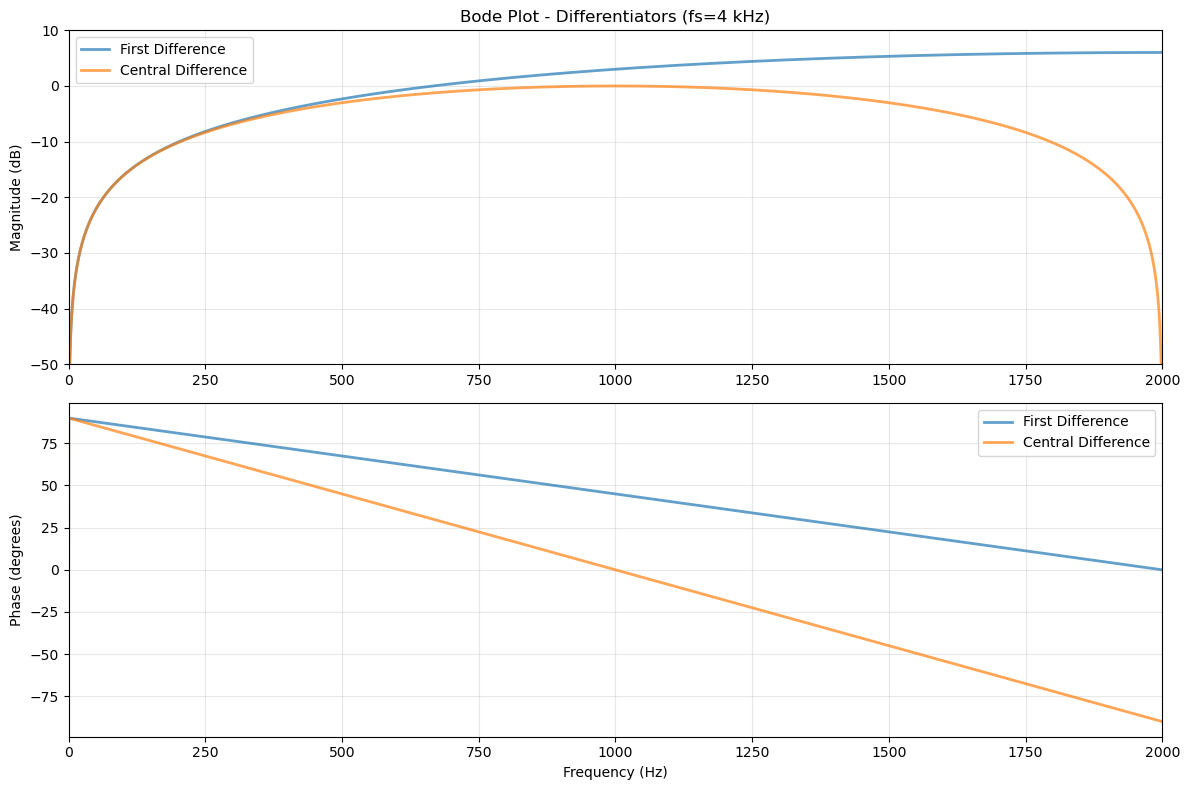

In [ ]:
# Parameters
fs = 4000  # 4 kHz sampling rate
f_max = fs / 2  # Nyquist frequency

# Design first difference differentiator: y[n] = x[n] - x[n-1]
b_first = [1, -1]
a_first = [1]

# Design central difference differentiator: y[n] = (x[n] - x[n-2]) / 2
b_central = [1, 0, -1]
a_central = [2]

# Compute frequency response
w_first, h_first = signal.freqz(b_first, a_first, fs=fs, worN=8192)
w_central, h_central = signal.freqz(b_central, a_central, fs=fs, worN=8192)

# Create Bode plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Magnitude plot (dB)
magnitude_first_db = 20 * np.log10(np.abs(h_first) + 1e-10)
magnitude_central_db = 20 * np.log10(np.abs(h_central) + 1e-10)

ax1.plot(w_first, magnitude_first_db, linewidth=2, label='First Difference', alpha=0.7)
ax1.plot(w_central, magnitude_central_db, linewidth=2, label='Central Difference', alpha=0.7)
ax1.set_ylabel('Magnitude (dB)')
ax1.set_title('Bode Plot - Differentiators (fs=4 kHz)')
ax1.grid(True, alpha=0.3)
ax1.legend()
ax1.set_xlim([0, f_max])
ax1.set_ylim([-50, 10])

# Phase plot (degrees)
phase_first_deg = np.angle(h_first, deg=True)
phase_central_deg = np.angle(h_central, deg=True)

ax2.plot(w_first, phase_first_deg, linewidth=2, label='First Difference', alpha=0.7)
ax2.plot(w_central, phase_central_deg, linewidth=2, label='Central Difference', alpha=0.7)
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Phase (degrees)')
ax2.grid(True, alpha=0.3)
ax2.legend()
ax2.set_xlim([0, f_max])

plt.tight_layout()
plt.show()

C:\Users\bensi\AppData\Local\Temp\ipykernel_36004\1718333419.py:36: RuntimeWarning: invalid value encountered in divide
  h_zoh = 2*np.sin(w_cic*np.pi*L/fs)/(w_cic*2*np.pi*L/fs)
C:\Users\bensi\AppData\Local\Temp\ipykernel_36004\1718333419.py:43: RuntimeWarning: invalid value encountered in divide
  h_foh = 4*np.sin(w_cic*np.pi*L/fs)**2 / (w_cic*2*np.pi*L/fs)**2
C:\Users\bensi\AppData\Local\Temp\ipykernel_36004\1718333419.py:47: RuntimeWarning: invalid value encountered in divide
  h_fohex = 4*np.sqrt(1+(w_cic*2*np.pi*L/fs)**2) * np.sin(w_cic*np.pi*L/fs)**2 / (w_cic*2*np.pi*L/fs)**2


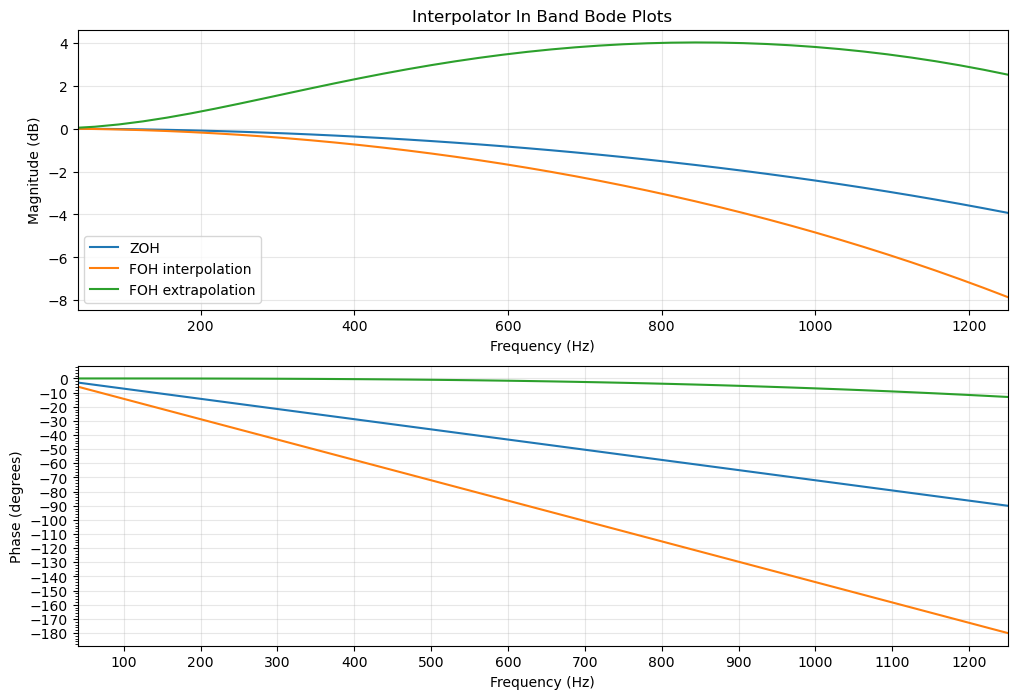

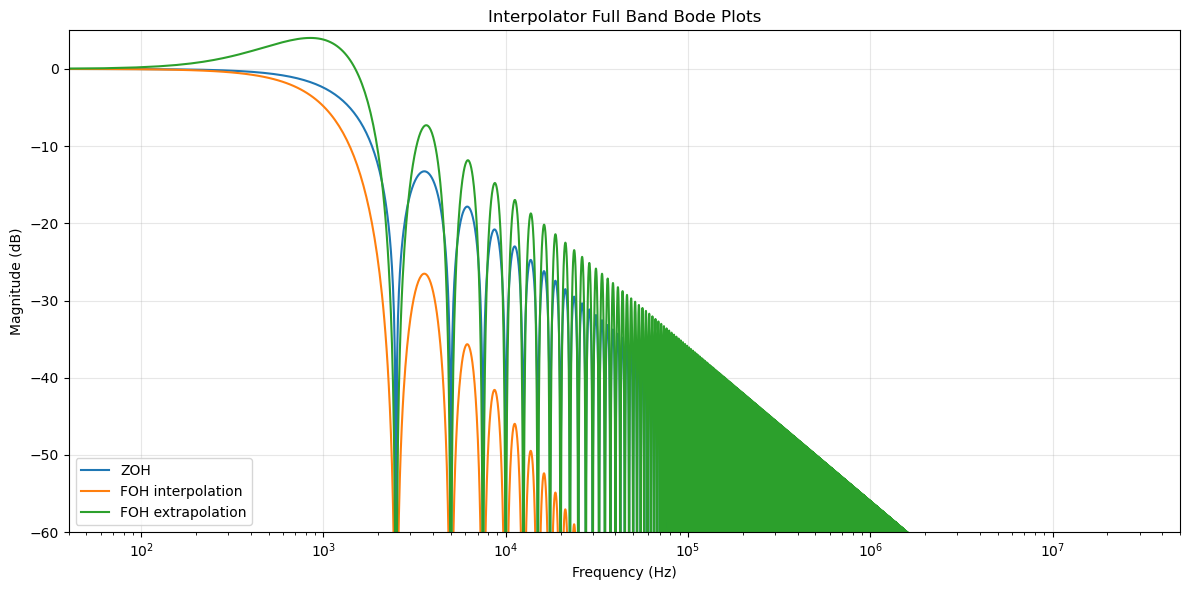

In [14]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import signal
mpl.rcParams['agg.path.chunksize'] = 10000 
# Design zero order hold (ZOH) interpolator
# ZOH transfer function: H(s) = (1 - exp(-s*Ts)) / s, where Ts is the sampling period
# In discrete-time: H(z) = (1 - z^-1) / (1 - z^-1) for interpolation by factor L

# Parameters
fs = 100000000  # Sampling frequency (Hz)
L = 40000  # Interpolation factor (same as decimation factor for reconstruction)
Ts = 1 / fs  # Sampling period (fs from previous cells)

# Design Nth order CIC filter
cic_order = 2
cic_b = np.ones(L) / L
cic_c = []
for _ in range(cic_order - 1):
    cic_c = np.convolve(cic_b, np.ones(L) / L)
cic_c = cic_c / np.sum(cic_c)  # Normalize

# Compute frequency response for CIC filter
w_cic, h_cic = signal.freqz(cic_b, [1], fs=fs, worN=1600000)
magnitude_cic_db = 20 * np.log10(np.abs(h_cic) + 1e-10)
phase_cic_deg = np.angle(h_cic, deg=True)

w_cic2, h_cic2 = signal.freqz(cic_c, [1], fs=fs, worN=1600000)
magnitude_cic2_db = 20 * np.log10(np.abs(h_cic2) + 1e-10)
phase_cic2_deg = np.angle(h_cic2, deg=True)
# Create transfer function

# ZOH in continuous time approximation
# H(s) = (1 - exp(-s*Ts)) / s ≈ 1 for low frequencies
# Magnitude and phase
h_zoh = 2*np.sin(w_cic*np.pi*L/fs)/(w_cic*2*np.pi*L/fs)
magnitude_zoh_db = 20 * np.log10(np.abs(h_zoh) + 1e-10)
phase_zoh_deg = -L/(2*fs) * w_cic * 360

# Design first order hold (FOH) interpolator
# FOH linearly interpolates between samples
# Transfer function: H(z) = (1 - z^-1) for single interpolation
h_foh = 4*np.sin(w_cic*np.pi*L/fs)**2 / (w_cic*2*np.pi*L/fs)**2
magnitude_foh_db = 20 * np.log10(np.abs(h_foh) + 1e-10)
phase_foh_deg = -L/(fs) * w_cic * 360

h_fohex = 4*np.sqrt(1+(w_cic*2*np.pi*L/fs)**2) * np.sin(w_cic*np.pi*L/fs)**2 / (w_cic*2*np.pi*L/fs)**2
magnitude_fohex_db = 20 * np.log10(np.abs(h_fohex) + 1e-10)
phase_fohex_deg = (np.atan(L/(fs) * w_cic) -L/(fs) * w_cic) * 360

# Plot ZOH response
fig_zoh, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

ax1.plot(w_cic[:int(1600000/L)+1], magnitude_zoh_db[:int(1600000/L)+1], linewidth=1.5, label='ZOH')
ax1.plot(w_cic[:int(1600000/L)+1], magnitude_foh_db[:int(1600000/L)+1], linewidth=1.5, label='FOH interpolation')
#ax1.plot(w_cic[:int(1600000/L)+1], magnitude_cic_db[:int(1600000/L)+1], 'b--', linewidth=1, label='CIC N=1') # CIC1 same as ZOH
#ax1.plot(w_cic2[:int(1600000/L)+1], magnitude_cic2_db[:int(1600000/L)+1], 'b:', linewidth=1, label='CIC N=2') # CIC2 same as FOH
ax1.plot(w_cic[:int(1600000/L)+1], magnitude_fohex_db[:int(1600000/L)+1], linewidth=1.5, label='FOH extrapolation')
ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('Magnitude (dB)')
ax1.set_title('Interpolator In Band Bode Plots')
ax1.grid(True, alpha=0.3)
ax1.set_xlim([40, w_cic[int(1600000/L)]])
#ax1.set_ylim([-60, 5])
ax1.legend(loc='lower left')

ax2.plot(w_cic[:int(1600000/L)+1], phase_zoh_deg[:int(1600000/L)+1], linewidth=1.5, label='ZOH')
ax2.plot(w_cic[:int(1600000/L)+1], phase_foh_deg[:int(1600000/L)+1], linewidth=1.5, label='FOH interpolation')
#ax2.plot(w_cic[:int(1600000/L)+1], phase_cic_deg[:int(1600000/L)+1], 'b--', linewidth=1, label='CIC N=1')
#ax2.plot(w_cic2[:int(1600000/L)+1], phase_cic2_deg[:int(1600000/L)+1], 'b:', linewidth=1, label='CIC N=2')
ax2.plot(w_cic[:int(1600000/L)+1], phase_fohex_deg[:int(1600000/L)+1], linewidth=1.5, label='FOH extrapolation')
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Phase (degrees)')
ax2.grid(True, alpha=0.3)
ax2.set_xlim([40, w_cic[int(1600000/L)]])
ax2.xaxis.set_major_locator(plt.MultipleLocator(100))
ax2.yaxis.set_major_locator(plt.MultipleLocator(10))
ax2.yaxis.set_minor_locator(plt.MultipleLocator(2))

fig_zfull, ax_zoh2 = plt.subplots(figsize=(12, 6))
ax_zoh2.semilogx(w_cic, magnitude_zoh_db, linewidth=1.5, label='ZOH')
ax_zoh2.semilogx(w_cic, magnitude_foh_db, linewidth=1.5, label='FOH interpolation')
#ax_zoh2.semilogx(w_cic, magnitude_cic_db, 'b--', linewidth=1, label='CIC N=1')
#ax_zoh2.semilogx(w_cic2, magnitude_cic2_db, 'b:', linewidth=1, label='CIC N=2')
ax_zoh2.semilogx(w_cic, magnitude_fohex_db, linewidth=1.5, label='FOH extrapolation')
ax_zoh2.set_xlabel('Frequency (Hz)')
ax_zoh2.set_ylabel('Magnitude (dB)')
ax_zoh2.set_title('Interpolator Full Band Bode Plots')
ax_zoh2.grid(True, alpha=0.3)
ax_zoh2.set_xlim([40, fs/2])
ax_zoh2.set_ylim([-60, 5])
ax_zoh2.legend(loc='lower left')


plt.tight_layout()
plt.show()



ValueError: s must be a scalar, or float array-like with the same size as x and y

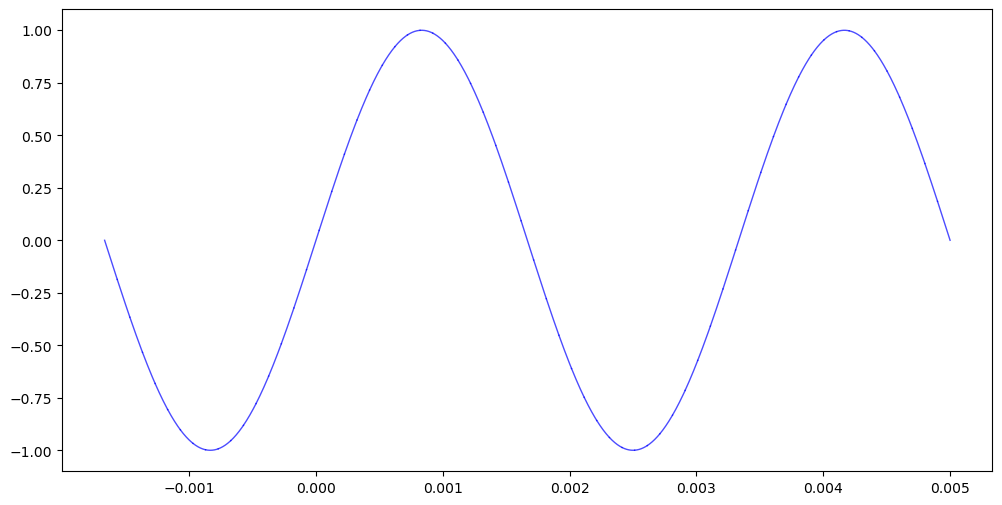

In [ ]:

# Generate timestream with sine wave input
t_stream = np.arange(-1/600, 1.5/300, Ts)  # timestream
t_stream_dec = np.arange(-1/600, 1.5/300, L*Ts)  # timestream after decimation
f_sine = 300  # Hz sine wave
sine_input = np.sin(2 * np.pi * f_sine * t_stream)
sin_input_dec = np.sin(2 * np.pi * f_sine * t_stream_dec)
sin_input_zeropad = np.zeros(len(sine_input))
sin_input_zeropad[::L] = sin_input_dec
# Apply ZOH filter (simple sample-and-hold)
sine_zoh = np.repeat(sine_input[::L], L)[:len(sine_input)]

#Apply FOH filter (linear interpolation)
sine_foh = np.interp(t_stream, t_stream_dec, np.concat([[0],sin_input_dec[:-1]]))

sine_fohex = np.zeros(len(sine_input))
for i in range(len(sine_fohex)):
    sine_fohex[i] = sin_input_dec[i//L]  + (sin_input_dec[i//L] - sin_input_dec[i//L - 1])*(i%L)/L

# Apply CIC filter
sine_cic = signal.lfilter(cic_b*L, [1], sin_input_zeropad)
sin_cic2 = signal.lfilter(cic_c*L, [1], sin_input_zeropad)


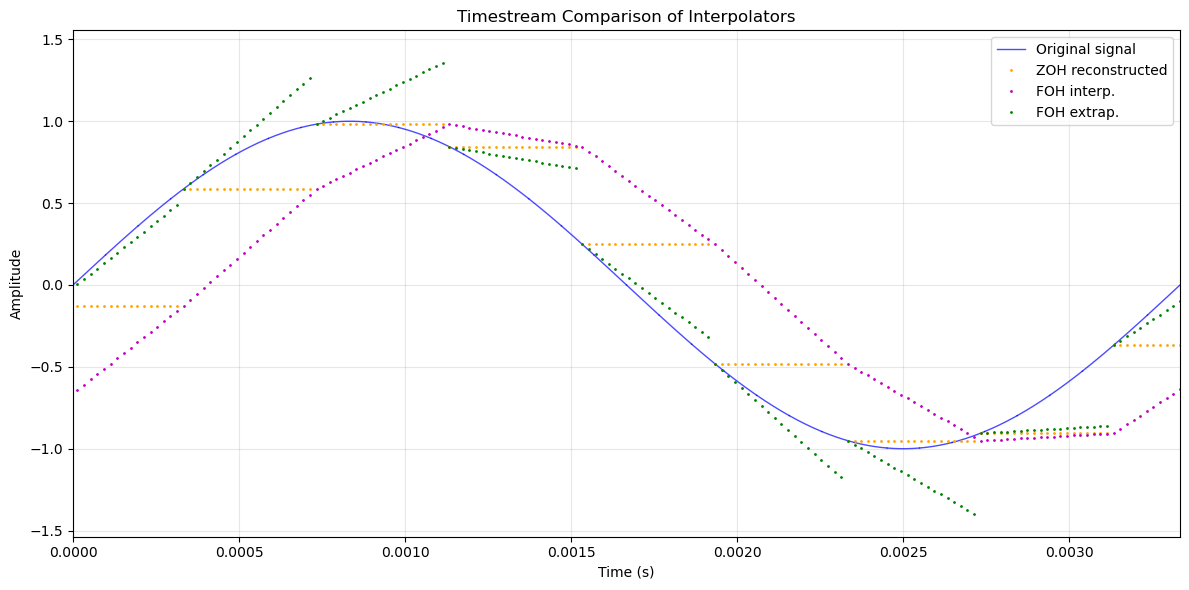

In [33]:


# Plot timestream comparison
fig_time, ax_time = plt.subplots(figsize=(12, 6))
ax_time.plot(t_stream, sine_input, 'b-', linewidth=1, label='Original signal', alpha=0.7)
#ax_time.plot(t_stream, sin_input_zeropad, 'k--', linewidth=2, label='Decimated signal', alpha=0.7)
ax_time.plot(t_stream[::2000], sine_zoh[::2000],'orange', marker='.', ms=2, linestyle='', label='ZOH reconstructed')
ax_time.plot(t_stream[::2000], sine_foh[::2000], 'm', marker='.', ms=2, linestyle='', label='FOH interp.')
ax_time.plot(t_stream[::2000], sine_fohex[::2000], 'g', marker='.', ms=2, linestyle='', label='FOH extrap.')
#ax_time.plot(t_stream, sine_cic, 'g-.', linewidth=1, label='CIC N=1', alpha=0.7)
#ax_time.plot(t_stream, sin_cic2, 'c-.', linewidth=1, label='CIC N=2', alpha=0.7)
ax_time.set_xlabel('Time (s)')
ax_time.set_ylabel('Amplitude')
ax_time.set_xlim([0, 1/300])
ax_time.set_title('Timestream Comparison of Interpolators')
ax_time.grid(True, alpha=0.3)
ax_time.legend()
plt.tight_layout()
plt.show()